In [1]:
import os 
import shutil
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime
from scipy.stats import ttest_ind, ttest_1samp, fisher_exact

import seaborn as sns
sns.set_theme(style='white')
from tqdm import tqdm

from scipy.stats import spearmanr, pearsonr, kruskal, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

from scripts.utils import get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, get_treatment_info, load_from_pickle

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


region_colors_dict = {
 'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

regions = list(region_colors_dict.keys())
region_colors = list(region_colors_dict.values())
simple_names = [s.split(' ')[0] for s in region_colors_dict.keys()]

sample_class_dict = dict(zip(sample_id_masks.keys(),[s.split(' ')[0] for s in sample_id_masks.values()]))

gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wzecaqsz because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Downloading scoring results for analysis

In [14]:
scanpy_res = pd.concat(load_from_pickle('./data/spatial_scanpy_score_results.pkl'))
scanpy_res.index = scanpy_res.index.get_level_values(1)

obs_data = pd.read_csv('./data/pathology_filtered_obs_with_regions.csv',index_col=0)

obs_data = pd.concat([obs_data,scanpy_res],axis=1) # Check the order if necessary

obs_data['predicted_region'] = pd.Categorical(obs_data['predicted_region'],categories = list(region_colors_dict.keys()))

obs_data = obs_data.rename(columns={'NLR associated':'High NLR-associated'})

## Gene set score violin plots (Figure 3a)

In [3]:
sns.set_theme(style='whitegrid')

# Set the region you want to compare against
region_of_interest = 'Club epithelium'

only_epithelial_regions = True

# Set the gene set modules
modules_of_interest = ['Club','MP19 Epithelial Senescence','HALLMARK_IL6_JAK_STAT3_SIGNALING','High NLR-associated']


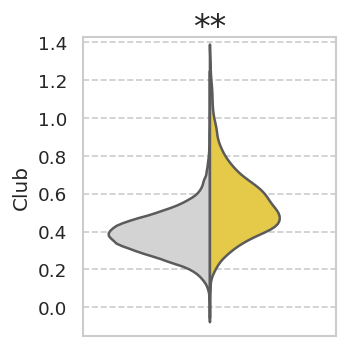

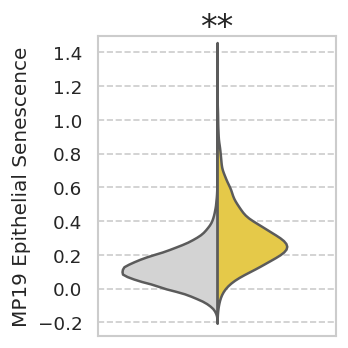

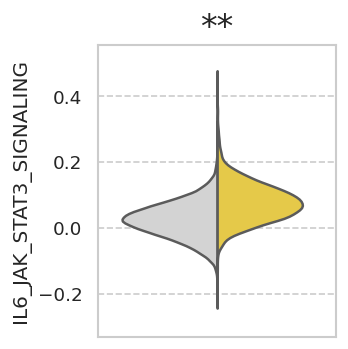

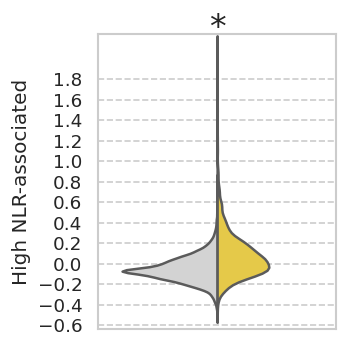

In [17]:

# Filter according to epithelial 
if only_epithelial_regions:
    df = obs_data[obs_data['predicted_region'].isin(regions[:4])]

else:
    df = obs_data.copy()

# Annotate all but the roi as 'Other'
region_selection_dict = dict(zip(regions,[region if region == region_of_interest else 'Other' for region in regions]))


for col in modules_of_interest:

    fig, ax = plt.subplots(figsize=(3, 3), dpi=120)

    df_to_plot = df[['sample_id',col,'predicted_region']]

    df_to_plot['regions_to_plot'] = df_to_plot['predicted_region'].map(region_selection_dict).astype('category')

    df_to_plot['regions_to_plot'] = df_to_plot['regions_to_plot'].cat.set_categories(['Other',region_of_interest])
    df_to_plot['foo'] = 'bar'

    sns.set_palette(sns.color_palette(['lightgrey',region_colors_dict[region_of_interest]]))

    sns.violinplot(data=df_to_plot,x='foo', hue='regions_to_plot', y=col,ax=ax,inner=None,split=True,legend=False)
    ax.get_legend().remove()

    # Plot y-axis lines between known interwals
    plt.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
    plt.yticks(np.arange(-1,2,0.2).astype(float))

    ymin = df_to_plot[col].min()-0.1
    ymax = df_to_plot[col].max()+0.1

    ax.set(ylim=(ymin, ymax))
    
    # Do the t-tests
    sample = df_to_plot[df_to_plot['regions_to_plot']==region_of_interest][col]
    control = df_to_plot[~(df_to_plot['regions_to_plot']==region_of_interest)][col]

    stat,p_val = ttest_ind(sample,control)

    ## Make p-value and magnitude requirements
    if p_val<0.05 and ((control.mean() < sample.quantile(0.1)) or (control.mean() > sample.quantile(0.9))):
        asterisks = '***'
    elif p_val<0.05 and ((control.mean() < sample.quantile(0.2)) or (control.mean() > sample.quantile(0.8))):
        asterisks = '**'
    elif p_val<0.05 and ((control.mean() < sample.quantile(0.3)) or (control.mean() > sample.quantile(0.7))):
        asterisks = '*'
    else:
        asterisks = ''
        
    ax.text(0, ymax+0.05, asterisks, fontsize=20,ha='center', va='center')
        
    ax.set_xticklabels([])
    ax.set_ylabel(col.replace('HALLMARK_','')) # Drop redundant string

    ax.set_xlabel('')
    plt.tight_layout()
    
    plt.savefig('./plots/score_violins/club_vs_other_epithelial/scanpy_'+col.replace('/','_')+'_score.pdf')
    plt.show()

# Save the plot source data
plot_data = df[modules_of_interest+['sample_id','predicted_region']]
plot_data['sample'] = plot_data['sample_id'].map(sample_id_masks)
plot_data = plot_data.drop(columns=['sample_id']).reset_index(drop=True) # Drop sample IDs
plot_data['regions_to_plot'] = plot_data['predicted_region'].map(region_selection_dict).astype('category')
plot_data.to_excel('./source_data/figure_3a.xlsx')

## Score correlation plots for epithelial subtypes (Figure 3b)

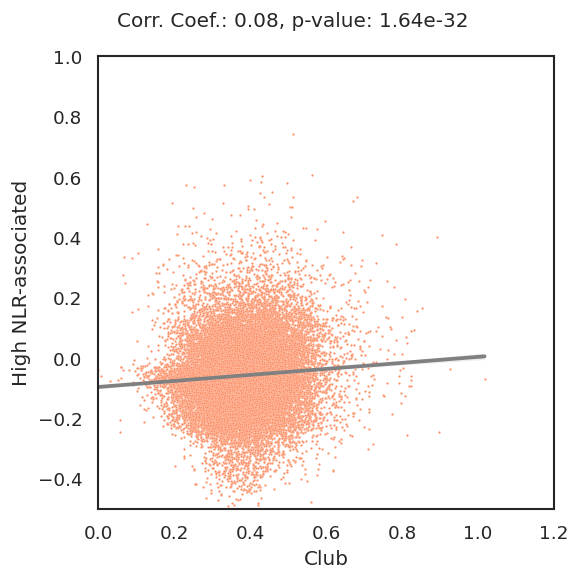

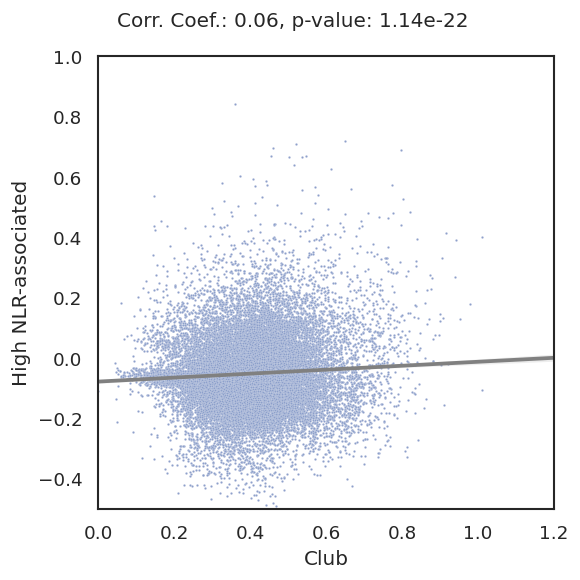

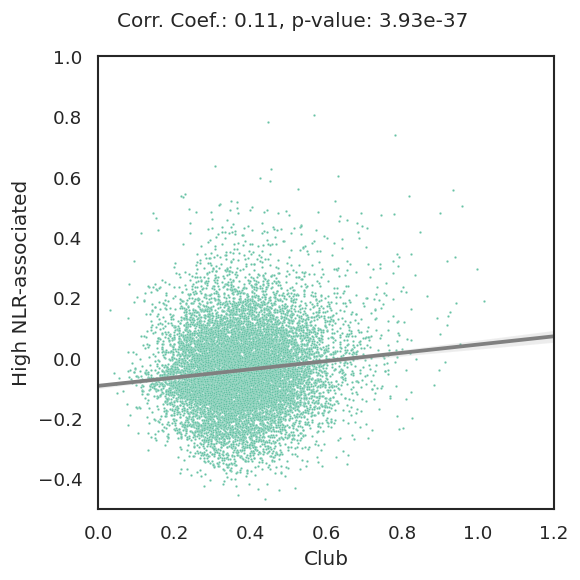

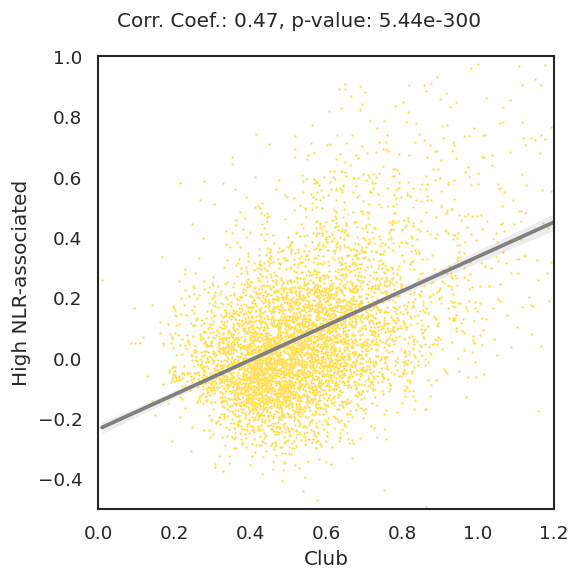

In [44]:
# This uses the same exact data as Figure 3a
sns.set_theme(style='white')

score1 = 'Club'
score2 = 'High NLR-associated'

for reg in regions[:4]:

    # Subset the correct region
    scores_df = obs_data[(obs_data['predicted_region'] == reg)]

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=score1, y=score2, data=scores_df, color = region_colors_dict[reg], linewidth=0.1, s=2, ax=ax) # 

    # add regression line to plot
    sns.regplot(x=score1, y=score2, data=scores_df, scatter=False, ax=ax,color='gray')

    ax.set_ylim(-0.5,1.0)
    ax.set_xlim(0,1.2)

    corr_coef, p_value = pearsonr(scores_df[score1], scores_df[score2])
    ax.text(x=0.05, y=1.1, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()
    plt.savefig('plots/score_correlations/'+score1+'_'+score2+'_in_'+'_'.join(sample_classes)+'_'+reg+'.png',dpi=1200)
    plt.show()


## Venn diagram of gene set overlaps (Figure 3c)

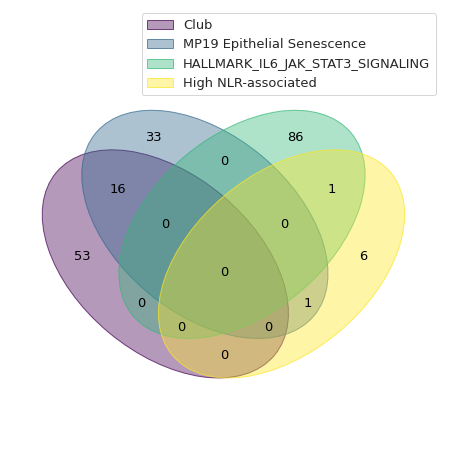

In [39]:
sns.set_theme(style='white')
from venn import venn

gene_set_df.rename(columns={'NLR associated':'High NLR-associated'},inplace=True)

set1_name = 'Club' 
set2_name = 'MP19 Epithelial Senescence'
set3_name = 'HALLMARK_IL6_JAK_STAT3_SIGNALING'
set4_name = 'High NLR-associated'
venn_data = {
            set1_name: set(gene_set_df[set1_name].dropna()),
            set2_name: set(gene_set_df[set2_name].dropna()),
            set3_name: set(gene_set_df[set3_name].dropna()),
            set4_name: set(gene_set_df[set4_name].dropna())
            }
fig,ax = plt.subplots(figsize=(8,8))
venn(venn_data,ax=ax)
plt.savefig('./plots/score_correlations/venn_'+set1_name+'_'+set2_name+'_'+set3_name+'_'+set4_name+'.pdf')
plt.show()

## GO:BP gene set enrichment dotplots (Figure 4a)

### Club region

In [85]:
## Enrichment done on padj < 0.05 Club region-specific markers on https://biit.cs.ut.ee/gprofiler/gost
club_enrichments = pd.read_csv('./data/club_gProfiler_hsapiens_01-03-2024_14-02-08__intersections.csv') 
club_deg_res = pd.read_excel('./supplementary_tables/supp_table_with_region_marker_fishers.xlsx',sheet_name='Club epithelium',index_col=0)
club_deg_res = club_deg_res[club_deg_res['adjusted p-value (Fishers exact test)']<0.05]

# Add a variable on the average position of the intersecting genes (lower integer = higher position)
means_list = []
for idx,row in club_enrichments.iterrows():
    genes = [g for g in row['intersections'].split(',') if club_deg_res['gene'].isin([g]).any()]
    means_list.append(np.mean(club_deg_res[club_deg_res['gene'].isin(genes)].index))
club_enrichments['mean_gene_position'] = pd.Series(means_list).astype(float)


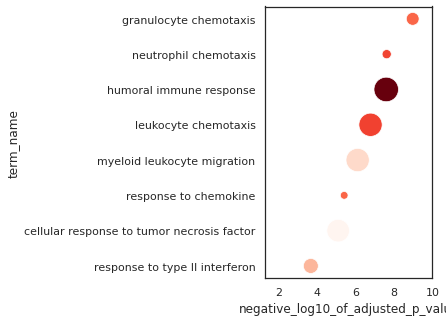

In [86]:
terms_to_plot = [
    'granulocyte chemotaxis',
    'humoral immune response',
    'neutrophil chemotaxis',
    'leukocyte chemotaxis',
    'response to chemokine',
    'myeloid leukocyte migration',
    'cellular response to tumor necrosis factor',
    'response to type II interferon'

]
plot_df = club_enrichments[['term_name','negative_log10_of_adjusted_p_value','intersection_size','term_size','mean_gene_position']]
plot_df = plot_df[plot_df['term_name'].isin(terms_to_plot)]

fig, ax = plt.subplots(figsize=(3,5))
sns.set_theme(style='whitegrid')
sns.scatterplot(
    x='negative_log10_of_adjusted_p_value',
    y='term_name',
    size='term_size',
    data=plot_df,
    sizes=(60,600),
    hue='mean_gene_position',
    palette='Reds_r',
    ax=ax)
ax.set_xlim(-np.log10(0.05),10)

plot_df_club = plot_df.copy()
plot_df_club['region'] = 'Club epithelium'

plt.legend().remove()
plt.savefig('./plots/club_region_gobp_enrichments.pdf')
plt.show()


### Immune region

In [87]:
## Enrichment done on padj < 0.05 Immune region-specific markers on https://biit.cs.ut.ee/gprofiler/gost
immune_enrichments = pd.read_csv('./data/immune_gProfiler_hsapiens_01-03-2024_14-01-28__intersections.csv')
immune_deg_res = pd.read_excel('./supplementary_tables/supp_table_with_region_marker_fishers.xlsx',sheet_name='Immune',index_col=0)
immune_deg_res = immune_deg_res[immune_deg_res['adjusted p-value (Fishers exact test)']<0.05]

# Add a variable on the average position of the intersecting genes (lower integer = higher position)
means_list = []
for idx,row in immune_enrichments.iterrows():
    genes = [g for g in row['intersections'].split(',') if immune_deg_res['gene'].isin([g]).any()]
    means_list.append(np.mean(immune_deg_res[immune_deg_res['gene'].isin(genes)].index))
immune_enrichments['mean_gene_position'] = means_list


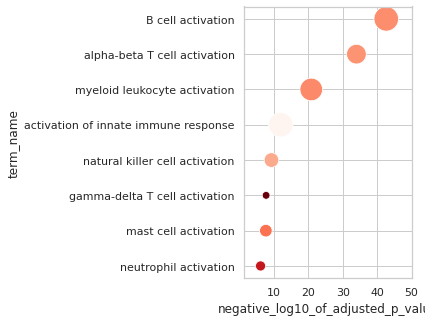

In [88]:
terms_to_plot = [
    'B cell activation',
    'alpha-beta T cell activation',
    'myeloid leukocyte activation',
    'activation of innate immune response',
    'natural killer cell activation',
    'neutrophil activation',
    'mast cell activation',
    'gamma-delta T cell activation'
]

plot_df = immune_enrichments[['term_name','negative_log10_of_adjusted_p_value','intersection_size','term_size','mean_gene_position']]
plot_df = plot_df[plot_df['term_name'].isin(terms_to_plot)] # Chemokines, chemotaxis...
fig, ax = plt.subplots(figsize=(3,5))
sns.set_theme(style='whitegrid')
sns.scatterplot(
    x='negative_log10_of_adjusted_p_value',
    y='term_name',
    size='term_size',
    data=plot_df,
    sizes=(60,600),
    hue='mean_gene_position',
    palette='Reds_r',
    ax=ax)
ax.set_xlim(-np.log10(0.05),50)

plot_df_immune = plot_df.copy()
plot_df_immune['region'] = 'Immune'

plt.legend().remove()
plt.savefig('./plots/immune_region_gobp_enrichments.pdf')
plt.show()

In [99]:
# Save the plot source data
plot_data = pd.concat([plot_df_club,plot_df_immune]).reset_index(drop=True)
plot_data.to_excel('./source_data/figure_4a.xlsx')

## Pseudobulk score correlation (Figure 4b)

In [55]:
sns.set_theme(style='white')


# Get the proportion of each region in each sample into a dataframe
def calculate_spot_proportions(obs_df = obs_data,sample_list = samples, region_list = regions):
    proportion_df = pd.DataFrame(index=samples,columns=region_list)
    for s in sample_list:

        slide = obs_df[obs_df['sample_id'] == s]
        val_counts = slide['predicted_region'].value_counts()

        # Add any missing regions
        for reg in region_list:
            if reg not in val_counts.index:
                val_counts.loc[reg] = 0 
        
        # Sort the values to a correct region order
        proportion_df.loc[s] = val_counts[region_list].values
    proportion_df = proportion_df.div(proportion_df.sum(axis=1),axis=0).astype(float)

    return(proportion_df)

proportion_df = calculate_spot_proportions()
proportion_df['sample_class'] = proportion_df.index.map(sample_class_dict)

In [66]:
roi = 'Club epithelium'
pseudobulk_df = pd.DataFrame()

for s in tqdm(samples,desc='Samples processed:'):

    # Ignore spots that belong to the region which' proportion you want to correlate (remove confounding effect)
    slide = sc.read_h5ad('./data/visium_with_regions/'+s+'_with_regions.h5ad')

    # Take out spots annotated as the region of interest
    slide = slide[slide.obs['predicted_region'] != roi]

    # Concatenate the raw count layer into a pseudobulk sample
    s_pseudobulk_df = pd.DataFrame(slide.layers['counts'].sum(axis=0).T,index=slide.var.index,columns=[s])
    
    # Merge to create a dataframe with samples as columns, genes as index
    pseudobulk_df = pd.merge(pseudobulk_df,s_pseudobulk_df,left_index=True,right_index=True,how='outer')

    del slide

# Fill empty
pseudobulk_df = pseudobulk_df.fillna(0)

# Make into an anndata object for scanpy compatibility
pseudobulk_adata = ad.AnnData(pseudobulk_df.values.T,var=pd.DataFrame(index=pseudobulk_df.index),obs=pd.DataFrame(index=pseudobulk_df.columns))

# Save the raw counts
pseudobulk_adata.layers['counts'] = pseudobulk_adata.X.copy()

# Preprocess and normalize using standard methods (NOTE: single-cell/spatial pipeline uses scran-normalization)
sc.pp.filter_genes(pseudobulk_adata,min_cells=10)
sc.pp.normalize_total(pseudobulk_adata,target_sum=1e4)
sc.pp.log1p(pseudobulk_adata)


Samples processed:: 100%|██████████| 48/48 [00:17<00:00,  2.67it/s]


In [70]:

# Score genes and add the identifier to obs
for mod in gene_set_df.columns:
    # NOTE: forgot to include random_state parameter here
    sc.tl.score_genes(pseudobulk_adata,gene_set_df[mod].dropna(),score_name=mod) 

# Concatenate with the sample-specific region proportion dataframe
proportion_df_pseudobulk_method = pd.concat([proportion_df,pseudobulk_adata.obs],axis=1)



### Plot the pseudobulk method correlation plots

In [95]:
sns.set_theme(style='white')

# Optional subsetting of treatment classes
classes_to_keep = ['BPH','TRNA','NEADT','CRPC'] 

treat_colors_dict = {
    'BPH':'#1f77b4',
    'TRNA':'#ff7f0e',
    'NEADT':'#2ca02c', 
    'CRPC':'#d62728',
}
 
sns.set_palette(sns.color_palette([treat_colors_dict[k] for k in classes_to_keep]))
df = proportion_df_pseudobulk_method[proportion_df_pseudobulk_method['sample_class'].isin(classes_to_keep)]

In [96]:
# Calculate correlation p-values
pvals = []
for mod in gene_set_df.columns:

    corr_coef, p_value = spearmanr(df[roi], df[mod])
    pvals.append(p_value)

# Correct p-values and save them into a dict
corrected_pvals = fdrcorrection(pvals,alpha=0.05,method='indep')
corrected_pvals_dict = dict(zip(gene_set_df.columns.tolist(),corrected_pvals[1]))


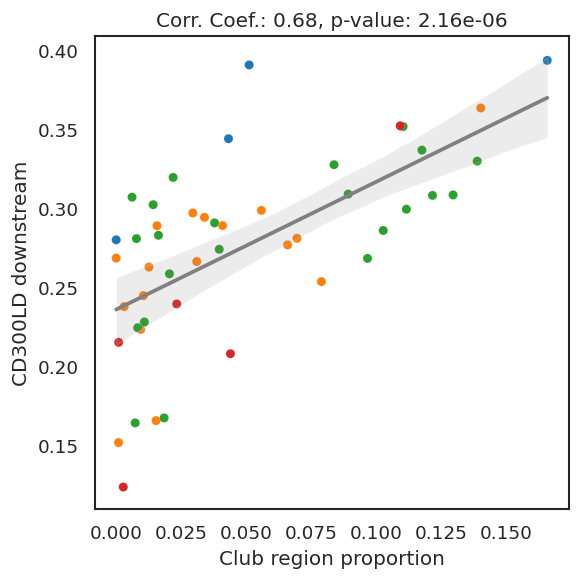

In [97]:

# Plot just the PMN-MDSC gene signature for the manuscript
for mod in ['CD300LD downstream']:

    plot_df = df[[roi,mod,'sample_class']]

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=roi, y=mod, data=plot_df, hue='sample_class', linewidth=0.1, s=30, ax=ax,legend=False) # 

    # add regression line to plot
    sns.regplot(x=roi, y=mod, data=plot_df, scatter=False, ax=ax,color='gray')

    corr_coef, _ = spearmanr(plot_df[roi], plot_df[mod])
    corrected_pval = corrected_pvals_dict[mod]

    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {corrected_pval:.2e}")
    ax.set_xlabel('Club region proportion') ### CHECK THAT IS CORRECT
    plt.tight_layout()

    plt.savefig('plots/score_correlations/'+roi.replace(' ','_')+'/region_proportion_vs_'+mod+'_'+'_'.join(classes_to_keep)+'.pdf')
    plt.show()

plot_df.index = plot_df.index.map(sample_id_masks)

# Save the plot source data
plot_df.to_excel('./source_data/figure_4b.xlsx')

## Gene set score in relation to region proximity (Figure 4c)

In [6]:
# Add the proximity spots information from csvs
for reg in [r for r in regions if 'Club' not in r]:
    # Load the proximity information mapping calculated in a python script
    df = pd.read_csv('./data/proximity_spot_ids/Club epithelium_to_'+reg+'_spot_annotation.csv',index_col=0)

    # Make into a dictionary and map
    proximity_mapping = df['Club epithelium_'+reg+'_proximity'].to_dict()
    obs_data['Club_'+reg+'_proximity'] = obs_data.index.map(proximity_mapping)


In [58]:
# Which samples, which regions & which score
sample_class = 'TRNA'
reg = 'Tumor'
score = 'CD300LD downstream'

plot_df = obs_data[obs_data['predicted_region'].isin(['Club epithelium',reg]) & (obs_data['sample_class'] == sample_class)]

# Mask the sample ids
plot_df['sample_id'] = plot_df['sample_id'].map(sample_id_masks)

plot_df['regions_to_plot'] = obs_data['predicted_region'].astype('str')

# Annotate the spots according to their proximity status
plot_df['regions_to_plot'] = plot_df['regions_to_plot'].replace({reg:f'distant {reg}'})
plot_df.loc[plot_df[f'Club_{reg}_proximity']=='Club epithelium','regions_to_plot'] = 'Club'
plot_df.loc[plot_df[f'Club_{reg}_proximity']==reg,'regions_to_plot'] = f'proximal {reg}'

# Drop the Club epithelium spots that are not proximal to the interacting region
plot_df = plot_df[~(plot_df['regions_to_plot'] == 'Club epithelium')]

plot_df['regions_to_plot'] = pd.Categorical(plot_df['regions_to_plot'],categories=['Club',f'proximal {reg}',f'distant {reg}'])
plot_df = plot_df[[score,'regions_to_plot','sample_id']]

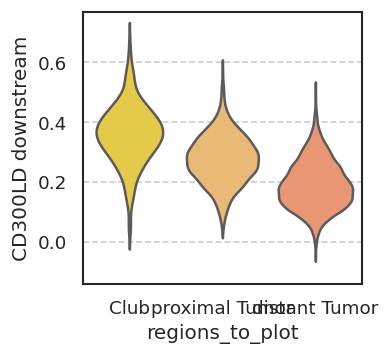

In [49]:
color_pal = [region_colors_dict['Club epithelium'],'#fcbc62',region_colors_dict['Tumor']]
sns.set_palette(sns.color_palette(color_pal))

fig, ax = plt.subplots(figsize=(3, 3), dpi=120)

# Plot y-axis lines between known interwals
ax.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
plt.yticks(np.arange(-1,2,0.2).astype(float))

sns.violinplot(data=plot_df, x='regions_to_plot', y=score,ax=ax,legend=False,inner=None)

ymin = plot_df[score].min()-0.1
ymax = plot_df[score].max()+0.1
ax.set(ylim=(ymin, ymax))

plt.savefig(save_path+'/club_proximity_score_enrichments/untreated_'+reg+'_'+score.replace(' ','_') + 'violins.pdf')
plt.show()

# Save the plot data
plot_df.reset_index(drop=True).to_excel('./source_data/figure_4c.xlsx')

## Scores in treatment-naïve vs. ADT samples (Figure 4d)

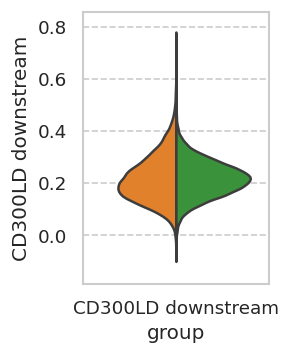

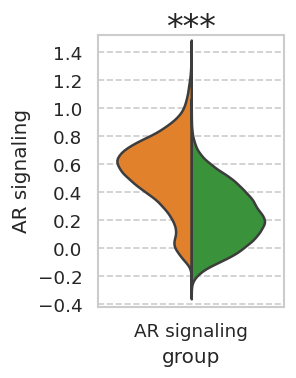

In [24]:
# CD300LD downstream = PMN-MDSC activity score
scores =  ['CD300LD downstream','AR signaling']

color_pal = ['#ff7f0e','#2ca02c']
sns.set_palette(sns.color_palette(color_pal))

for col in scores:
    df_to_plot = obs_data[obs_data['sample_class'].isin(['TRNA','NEADT'])].copy()

    fig, ax = plt.subplots(figsize=(2, 3), dpi=120)

    ax.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
    plt.yticks(np.arange(-1,2,0.2).astype(float))

    df_to_plot['group'] = col

    sns.violinplot(df_to_plot,x='group',hue='sample_class',y=col,ax=ax, inner=None,split=True)

    ymin = df_to_plot[col].min()-0.1
    ymax = df_to_plot[col].max()+0.1
    ax.set(ylim=(ymin, ymax))
    plt.legend().remove()

    # Do the t-tests
    sample = df_to_plot[df_to_plot['sample_class']=='NEADT'][col]
    control = df_to_plot[(df_to_plot['sample_class']=='TRNA')][col]

    stat,p_val = ttest_ind(sample,control)

    ## Make p-value and magnitude requirements
    if p_val<0.05 and ((control.mean() < sample.quantile(0.1)) or (control.mean() > sample.quantile(0.9))):
        asterisks = '***'
    elif p_val<0.05 and ((control.mean() < sample.quantile(0.2)) or (control.mean() > sample.quantile(0.8))):
        asterisks = '**'
    elif p_val<0.05 and ((control.mean() < sample.quantile(0.3)) or (control.mean() > sample.quantile(0.7))):
        asterisks = '*'
    else:
        asterisks = ''
        
    ax.text(0, ymax+0.05, asterisks, fontsize=20,ha='center', va='center')

    plt.savefig(save_path+'/club_proximity_score_enrichments/bulk_'+col.replace(' ','_') + 'violins.pdf')

    plt.show()

plot_df = obs_data[obs_data['sample_class'].isin(['TRNA','NEADT'])][['sample_class','sample_id'] + scores]
plot_df['sample_id'] = plot_df['sample_id'].map(sample_id_masks)

plot_df.reset_index(drop=True).to_excel('./source_data/figure_4d.xlsx')


## Gene set enrichment analysis of gene sets on region-specific gene markers (Supp Table S8, Supp Figure S5)


In [13]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df


In [14]:
region_gene_set_enrichment_df =  pd.DataFrame(index=gene_set_df.columns,columns=regions)

for reg in tqdm(regions,desc='Regions'):
    for set_name in gene_set_df.columns:
        region_markers = check_top_markers(reg)['gene'].tolist()
        cluster_markers = gene_set_df[set_name].dropna().tolist() 

        all_genes_marker_check = check_top_markers(reg,p_thresh=1.1)['gene'].tolist()
        n_universe = len(all_genes_marker_check)


        n_region_markers = len(region_markers)
        n_cluster_markers = len([g for g in  cluster_markers if g in all_genes_marker_check])


        cluster_region_marker_overlap = list(np.intersect1d(region_markers,cluster_markers))

        a = len(cluster_region_marker_overlap)# Overlapping genes
        b = len([g for g in cluster_markers if g not in region_markers]) # YES cluster markers NO region markers
        c = len([g for g in region_markers if g not in cluster_markers]) # NO cluster markers YES region markers
        d = n_universe - a -b -c # NO either (rest of the genes)
        arr = np.array([a,b,c,d]).reshape(2,2)
        stat, pval = fisher_exact(arr,alternative='greater')

        region_gene_set_enrichment_df.loc[set_name,reg] = pval
        
# Extract all p-values from the dataframe
p_values = region_gene_set_enrichment_df.values.flatten()

# Adjust p-values using Benjamini-Hochberg method
reject, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Replace the p-values in the dataframe with the adjusted p-values
region_gene_set_enrichment_df.iloc[:,:] = adj_p_values.reshape(region_gene_set_enrichment_df.shape)

# Now all p-values in the 'region_gene_set_enrichment_df' dataframe have been adjusted using the BH method


Regions: 100%|██████████| 8/8 [01:32<00:00, 11.56s/it]


In [15]:
# Create a dictionary with gene markers-gene set overlaps
region_overlaps_dict = {'Adjusted p-values':region_gene_set_enrichment_df}

for reg in regions:
#reg = 'Club epithelium'
    region_markers = check_top_markers(reg)['gene'].tolist()

    gene_overlaps_dictionary = {}

    for gset in region_gene_set_enrichment_df.index:
        if region_gene_set_enrichment_df.loc[gset,reg] < 0.05:
            gene_overlaps_dictionary[gset] = sorted(list(set(region_markers).intersection(set(gene_set_df[gset].tolist()))))
            
        else:
            gene_overlaps_dictionary[gset] = np.nan

    region_overlaps_dict[reg] = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in gene_overlaps_dictionary.items() ])).T

### Write the enrichment padj-values and overlaps into an excel file (Supp Table S8)

In [16]:
# Create a Pandas Excel writer using xlsxwriter as the engine
writer = pd.ExcelWriter('supplementary_tables/gene_set_enrichment_on_region_marker_genes_BH_adjusted_pvals.xlsx', engine='xlsxwriter')

# Iterate through the dictionary and write each sheet to the Excel file
for sheet_name, data in region_overlaps_dict.items():
    data.to_excel(writer, sheet_name=sheet_name, index=True)

# Save the Excel file
writer.save()

### Plot top enrichments into a dotplot (Supp Figure S5)

In [8]:
dat = pd.read_excel('supplementary_tables/gene_set_enrichment_on_region_marker_genes_BH_adjusted_pvals.xlsx',index_col=0)

overlaps = {}
for reg in regions:
    overlaps[reg] = pd.read_excel('supplementary_tables/gene_set_enrichment_on_region_marker_genes_BH_adjusted_pvals.xlsx',index_col=0,sheet_name=reg).T

n_top = 5
filter_kw = '^MP' #HALLMARK

term_list = []
for reg in regions:
    term_list += dat[reg].loc[dat.index.str.contains(filter_kw)].sort_values()[:n_top].index.tolist()

overlap_len_df = pd.DataFrame(index = term_list, columns=regions)
for reg in regions:
    for term in term_list:
        overlap_len_df.loc[term,reg] = len(overlaps[reg][term].dropna())
overlap_len_df_plot_format = overlap_len_df.reset_index(names='term').melt('term').rename(columns={'value':'overlap'})

term_list = dat.index[dat.index.str.contains(filter_kw)]

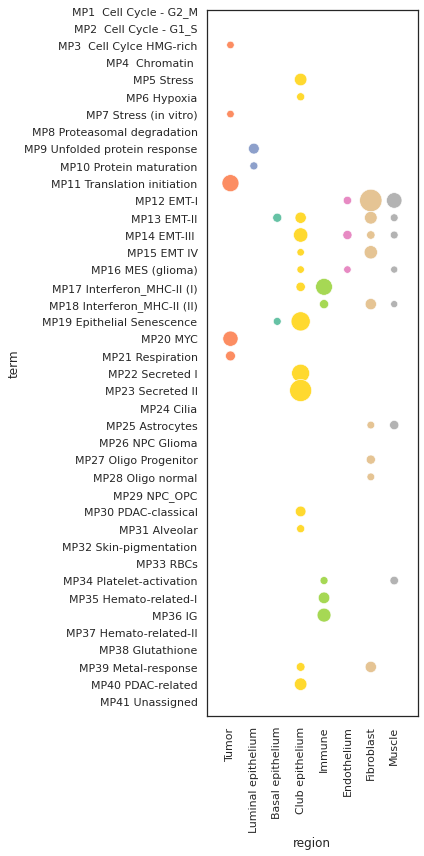

In [36]:
plot_df = dat.copy()

if filter_kw == 'HALLMARK':
    plot_df.index = [s.replace('HALLMARK_','') for s in plot_df.index.tolist()]
    term_list = [s.replace('HALLMARK_','') for s in term_list]

plot_df = plot_df.loc[term_list].reset_index(names='term').melt('term')


plot_df.loc[plot_df['value'] >= 0.05,'value'] = np.nan
plot_df['value'] = -np.log10(plot_df['value'])
plot_df['value'] = plot_df['value'].clip(upper=30) # Cap at a value for contrast
plot_df['overlap'] = overlap_len_df_plot_format['overlap'].copy()

# Define the category labels
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
# Cut the data into 5 custom-named categories
plot_df['value_cat'] = pd.cut(plot_df['value'], bins=5, labels=labels)

# Map regions onto a numberical scale so that the x-axis can be adjusted
plot_df['region'] = plot_df['variable'].map(dict(zip(regions,np.arange(len(regions))+1)))


fig, ax = plt.subplots(figsize=(6,12))
sns.scatterplot(data=plot_df,
                x = 'region',
                y = 'term',
                size='value',
                hue='variable',
                #hue='value_cat',
                #palette='magma',
                palette=sns.color_palette(region_colors),
                sizes=(50,500),
                ax=ax,
                #dropna=False
                )

ax.set_xlim(0,9)
ax.set_yticks(term_list)
ax.set_xticks(np.arange(len(regions))+1)
ax.set_xticklabels(regions,rotation=90)

plt.legend().remove()
plt.tight_layout()
plt.savefig('plots/'+filter_kw+'_gene_set_enrichments_on_regions_dotplot.pdf')
plt.show()